# Прогнозирование времени продажи недвижимости

Участники.
- Пеньков Георгий K3341
- Пиотуховский Александр K3341

**Цель проекта**  
Построить модель, которая будет предсказывать, сколько времени понадобится для продажи объекта недвижимости, основываясь на характеристиках объекта и рыночных данных.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Другие настройки
pd.set_option('display.max_columns', None)

# Загрузка данных и обзор

Скачаем датасет:

In [ ]:
import os
import kagglehub

dataset_path = kagglehub.dataset_download("litvinenko630/real-estate-saint-petersburg-2014-2019")

print("Path to dataset files:", dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/litvinenko630/real-estate-saint-petersburg-2014-2019/versions/1


Имеем датасет `real_estate_data.csv`

In [ ]:
df = pd.read_csv(dataset_path + "/real_estate_data.csv", sep="\t")
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [ ]:
print(f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

Dataset has 23699 rows and 22 columns.


Признак `days_exposition` - наша метка, которую мы попробуем предсказать. Рассмотрим другие признаки:

In [ ]:
df.dtypes

,0
total_images,int64
last_price,float64
total_area,float64
first_day_exposition,object
rooms,int64
ceiling_height,float64
floors_total,float64
living_area,float64
floor,int64
is_apartment,object


# Data understanding

Взглянем на признаки более подробно и попробуем прикинуть, как они могут влиять на days_exposition. Для этого составим таблицу со следующими столбцами:

- **Признак** - название столбца из df  
- **Пояснение** - пояснение признака  
- **Категория** - разделим все признаки на 3 категории:  
    1. Объявление - признак говорит об объявлении (пр. total_images, last_price)
    2. Квартира - признак говорит что-то о квартире (пр. total_area, rooms)
    3. Распололжеение - местоположение квартики и "качество" этого расположения (пр. locality_name, airports_nearest)
- **Тип** - numerical или categorical
- **Ожидание** - текущее предположение о важности этого признака для days_exposition. 3 значения: high, medium, low
- **Комментарий** - комментарий по поводу столбца "ожидание"

| Признак              | Пояснение                                   | Категория    | Тип                | Ожидание | Комментарий                                                                                                                                                    |  |
| -------------------- | ------------------------------------------- | ------------ | ------------------ | -------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------- |  |
| total_images         | число фотографий квартиры в объявлении      | Объявление   | numerical          | high     | Мало кто будет покупать недвижимость, в объявлении которой нет/мало картинок                                                                                   |  |
| last_price           | цена на момент снятия с публикации          | Объявление   | numerical          | high     | Адекватная цена должна сильно влиять на спрос. Хотя, с учетом того, что это цена уже на этапе сделки (последняя цена), она уже может быть “адекватной”         |  |
| locality_name        | название населённого пункта                 | Расположение | categorical        | high     | Квартиры в поселках (и в других насел. пунктах кроме СПб) будут иметь меньший спрос, чем в СПб. Но нужно проверить                                             |  |
| first_day_exposition | дата публикации объявления                  | Объявление   | categorical (date) | high     | Должны быть периоды времени, когда квартиры продаются активнее                                                                                                 |  |
| total_area           | площадь квартиры в квадратных метрах        | Квартира     | numerical          | high     | Маленькие или очень большие квартиры должны продаваться медленнее, чем более “популярные”                                                                      |  |
| rooms                | количество комнат                           | Квартира     | numerical          | medium   | Похоже на total_area                                                                                                                                           |  |
| living_area          | жилая площадь в квадратных метрах           | Квартира     | numerical          | medium   | Похоже на total_area                                                                                                                                           |  |
| floor                | этаж                                        | Квартира     | numerical          | medium   | Квартиры на 1м или последнем этаже могут дольше продаваться                                                                                                    |  |
| is_apartment         | Является ли жилье апартаментами             | Квартира     | categorical        | medium   | Возможно, апартаменты продаются хуже (медленнее) чем квартиры                                                                                                  |  |
| studio               | Является ли жилье студией                   | Квартира     | categorical        | medium   | Похоже на rooms                                                                                                                                                |  |
| balcony              | число балконов                              | Квартира     | numerical          | medium   | Для кого-то может быть важным наличие балкона. Но большое кол-во балконов может указывать на большую квартиру, которая, скорее всего, будет долго продаваться. |  |
| cityCenters_nearest  | расстояние до центра города                 | Расположение | numerical          | medium   | Похоже на locality_name, но дает больше информации о жилье в СПб.                                                                                              |  |
| ceiling_height       | Высота потолка (м)                          | Квартира     | numerical          | low      | Квартиры с низким потолком могут медленно продаваться                                                                                                          |  |
| floors_total         | всего этажей в доме                         | Квартира     | numerical          | low      | Как будто не особо важно, сколько этажей в доме                                                                                                                |  |
| open_plan            | Свободная ли планировка                     | Квартира     | categorical        | low      | Свободная планировка обычно присутствует в современных домах, так онаа может косвенно влиять на время продажи                                                  |  |
| kitchen_area         | площадь кухни в квадратных метрах           | Квартира     | numerical          | low      | Похоже на total_area и living_area.                                                                                                                            |  |
| airports_nearest     | расстояние до ближайшего аэропорта в метрах | Расположение | numerical          | low      | Очень близкое расположение к аэропорту может влиять на спрос, но после некоторого критического значение этот признак маловажен                                 |  |
| parks_around3000     | число парков в радиусе 3 км                 | Расположение | numerical          | low      | Жилье с парками должно быстрее продаваться, хотя влияние довольно косвенное                                                                                    |  |
| parks_nearest        | расстояние до ближайшего парка (м)          | Расположение | numerical          | low      | Похоже на parks_around3000                                                                                                                                     |  |
| ponds_around3000     | число водоёмов в радиусе 3 км               | Расположение | numerical          | low      | Похоже на parks_around3000, но для водоемов.                                                                                                                   |  |
| ponds_nearest        | расстояние до ближайшего водоёма (м)        | Расположение | numerical          | low      | Похоже на parks_around3000, но для водоемов.                                                                                                                   |  |

Отсортировав по "Ожидание", видим следующие важные для days_exposition признаки:
1. total_images
2. last_price
3. locality_name
4. first_day_exposition
5. total_area (тут может быть и похожие признаки, например, rooms или living_area)

# Data Exploration

## Корреляции
Проверим значимые признаки матрицей корреляции:

<Axes: >

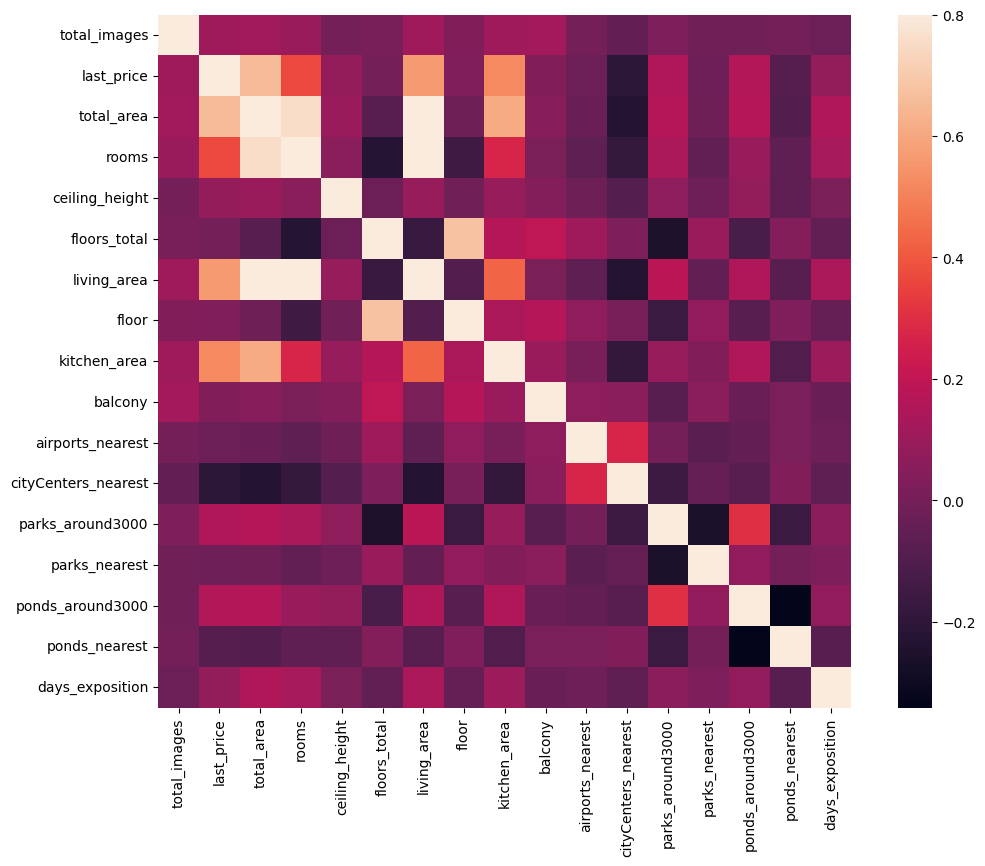

In [ ]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation_matrix, vmax=0.8, square=True)

Видно, что rooms, living_area и total_area имеют высокую корреляцию.
А вот с days_exposition корреляций признаков почти нет.

## Распределения

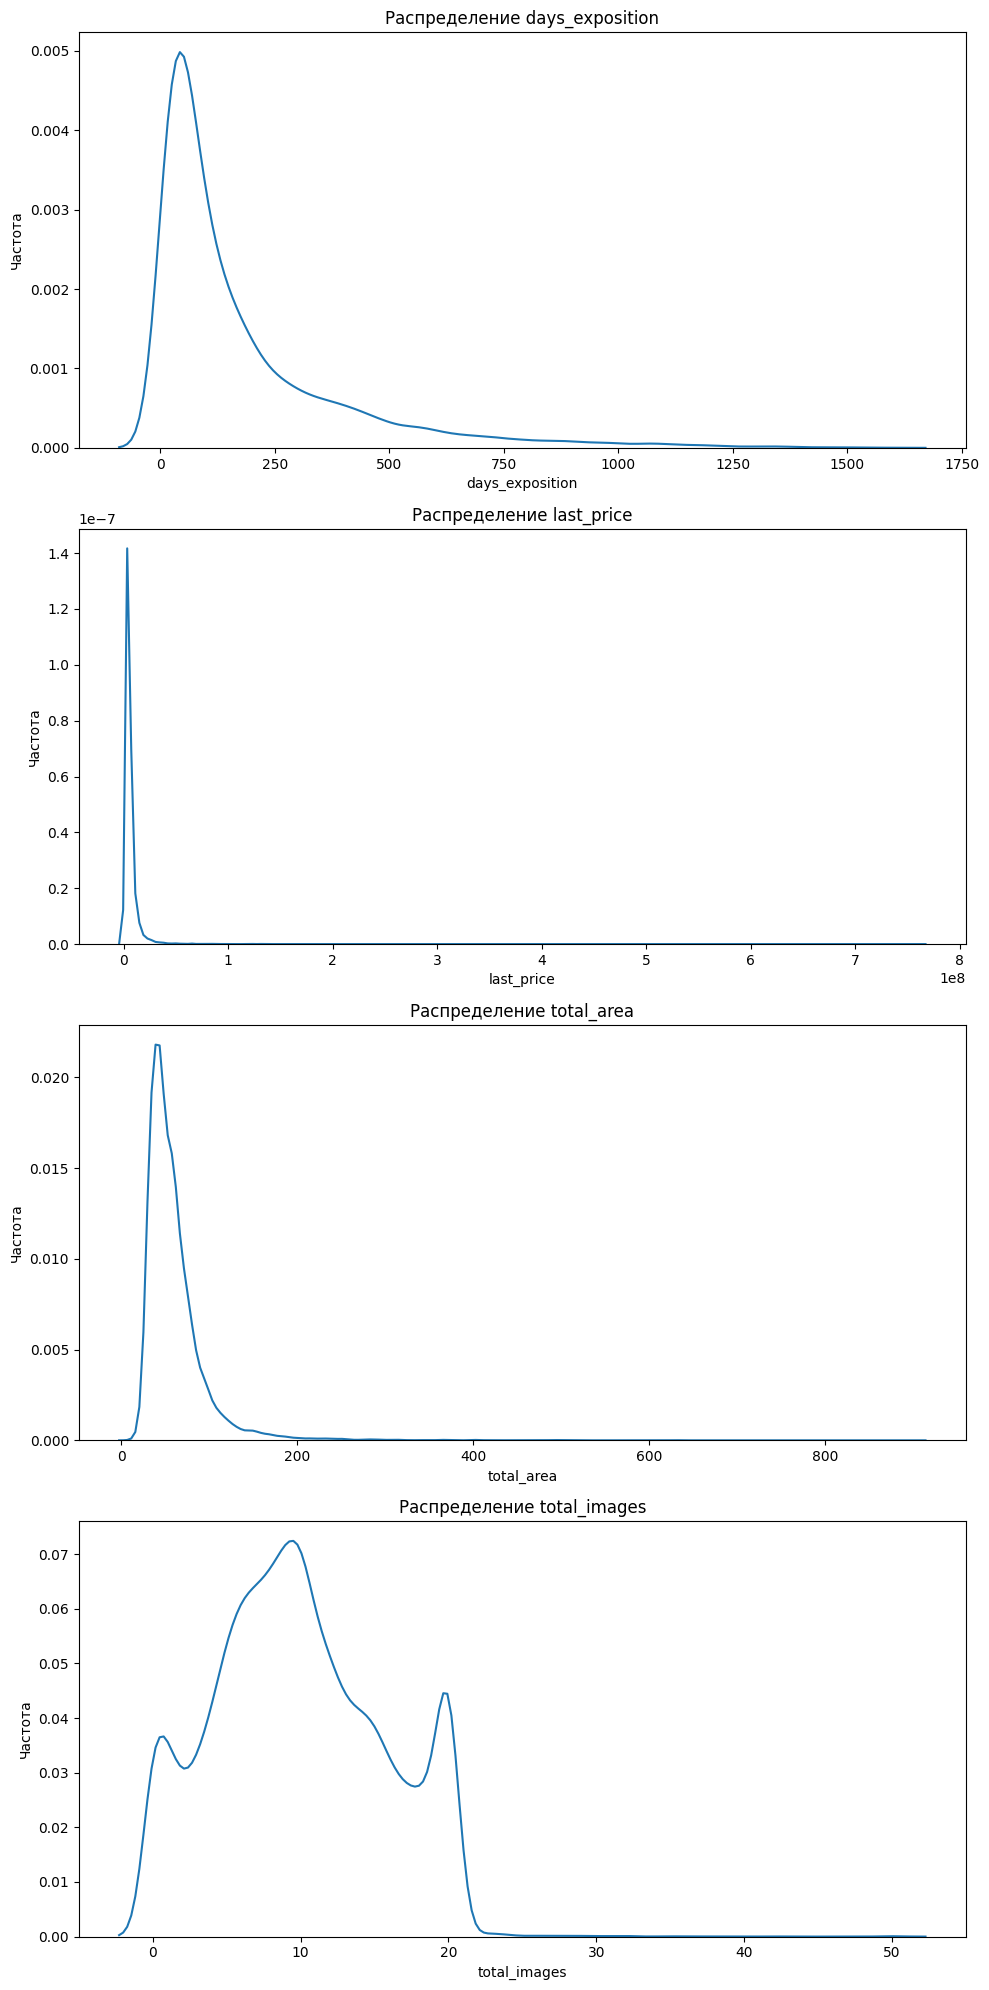

In [ ]:
key_columns = ['days_exposition','last_price', 'total_area', 'total_images']

fig, axes = plt.subplots(len(key_columns), 1, figsize=(10, 20))
for i, column in enumerate(key_columns):
    sns.kdeplot(df[column].dropna(), ax=axes[i])
    # axes[i].hist(df[column].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(f"Распределение {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Частота")

plt.tight_layout()
plt.show()


## Пропуски
Посмотрим на пропуски в данных

In [ ]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df) * 100).sort_values(ascending=False)
missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

In [ ]:
missing_data

,Total,Percent
is_apartment,20924,88.290645
parks_nearest,15620,65.909954
ponds_nearest,14589,61.559559
balcony,11519,48.605426
ceiling_height,9195,38.799105
airports_nearest,5542,23.384953
cityCenters_nearest,5519,23.287902
ponds_around3000,5518,23.283683
parks_around3000,5518,23.283683
days_exposition,3181,13.422507


Пропуски
1. Признаки с наибольшим количеством пропусков:  
  * is_apartment: 88.3% пропусков.
  * parks_nearest и ponds_nearest: более 60% пропусков.
  * balcony: почти 50% пропусков.
  * ceiling_height: около 39% пропусков.
2. Целевая переменная days_exposition:  
  * Пропущено около 13.4% данных.

# Data Preparation

## Удаление пропусков
Обработаем отсутствующие значения

In [ ]:
columns_to_drop = missing_data[missing_data['Percent'] > 25].index.tolist()
columns_to_keep = missing_data[missing_data['Percent'] <= 25].index.tolist()

data_cleaned = df.copy()

# Отбрасываем столбцы с более чем 25% отсутствующих значений
data_cleaned.drop(columns=columns_to_drop, inplace=True)

# Заполняем пропущенные числовые значения медианой
numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
data_cleaned[numerical_cols] = data_cleaned[numerical_cols].fillna(data_cleaned[numerical_cols].median())

# Заполняем категориальные значения значением "Unknown"
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].fillna("Unknown")

# Повторно анализируем очищенный набор данных на предмет недостающих значений
remaining_missing = data_cleaned.isnull().sum().sum()

In [ ]:
print("Удалённые колонки:", columns_to_drop)
print("Оставшиеся пропущенные значения:", remaining_missing)

Удалённые колонки: ['is_apartment', 'parks_nearest', 'ponds_nearest', 'balcony', 'ceiling_height']
Оставшиеся пропущенные значения: 0


Удалены столбцы с более чем 25% пропусков: `is_apartment`, `parks_nearest`, `ponds_nearest`, `balcony`, `ceiling_height`

Оставшиеся пропуски устранены:
* Числовые значения заполнены медианой.
* Категориальные значения заменены на "Unknown".

## Кодирование категориальных признаков

In [ ]:
# Идентифицируем категориальные столбцы
categorical_cols_cleaned = data_cleaned.select_dtypes(include=['object']).columns

# one-hot кодирование категориальных столбцов
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_cols_cleaned, drop_first=True)

data_encoded_info = data_encoded.info()

data_encoded_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Columns: 1869 entries, total_images to locality_name_село Шум
dtypes: bool(1856), float64(10), int64(3)
memory usage: 44.3 MB


In [ ]:
locality_counts = data_cleaned['locality_name'].value_counts()
data_cleaned['locality_name_encoded'] = data_cleaned['locality_name'].map(locality_counts)

data_cleaned.drop(columns=['locality_name'], inplace=True)

data_cleaned_info = data_cleaned.info()
data_cleaned_head = data_cleaned.head()

data_cleaned_info, data_cleaned_head[['locality_name_encoded']]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_images           23699 non-null  int64  
 1   last_price             23699 non-null  float64
 2   total_area             23699 non-null  float64
 3   first_day_exposition   23699 non-null  object 
 4   rooms                  23699 non-null  int64  
 5   floors_total           23699 non-null  float64
 6   living_area            23699 non-null  float64
 7   floor                  23699 non-null  int64  
 8   studio                 23699 non-null  bool   
 9   open_plan              23699 non-null  bool   
 10  kitchen_area           23699 non-null  float64
 11  airports_nearest       23699 non-null  float64
 12  cityCenters_nearest    23699 non-null  float64
 13  parks_around3000       23699 non-null  float64
 14  ponds_around3000       23699 non-null  float64
 15  da

(None,
    locality_name_encoded
 0                  15721
 1                    440
 2                  15721
 3                  15721
 4                  15721)

In [ ]:
# Преобразование временных данных
data_cleaned['first_day_exposition'] = pd.to_datetime(data_cleaned['first_day_exposition'], errors='coerce')

data_cleaned['exposition_year'] = data_cleaned['first_day_exposition'].dt.year
data_cleaned['exposition_month'] = data_cleaned['first_day_exposition'].dt.month
data_cleaned['exposition_day'] = data_cleaned['first_day_exposition'].dt.day
data_cleaned['exposition_weekday'] = data_cleaned['first_day_exposition'].dt.weekday  # 0 = Monday, 6 = Sunday

data_cleaned.drop(columns=['first_day_exposition'], inplace=True)

data_cleaned_info = data_cleaned.info()
data_cleaned_head = data_cleaned.head()

data_cleaned_info, data_cleaned_head[['exposition_year', 'exposition_month', 'exposition_day', 'exposition_weekday']]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_images           23699 non-null  int64  
 1   last_price             23699 non-null  float64
 2   total_area             23699 non-null  float64
 3   rooms                  23699 non-null  int64  
 4   floors_total           23699 non-null  float64
 5   living_area            23699 non-null  float64
 6   floor                  23699 non-null  int64  
 7   studio                 23699 non-null  bool   
 8   open_plan              23699 non-null  bool   
 9   kitchen_area           23699 non-null  float64
 10  airports_nearest       23699 non-null  float64
 11  cityCenters_nearest    23699 non-null  float64
 12  parks_around3000       23699 non-null  float64
 13  ponds_around3000       23699 non-null  float64
 14  days_exposition        23699 non-null  float64
 15  lo

(None,
    exposition_year  exposition_month  exposition_day  exposition_weekday
 0             2019                 3               7                   3
 1             2018                12               4                   1
 2             2015                 8              20                   3
 3             2015                 7              24                   4
 4             2018                 6              19                   1)

`first_day_exposition` преобразован в формат даты, были выделены следующие признаки:
* exposition_year: Год публикации объявления.
* exposition_month: Месяц публикации.
* exposition_day: День месяца.
* exposition_weekday: День недели (0 = понедельник, 6 = воскресенье).  

Исходный столбец `first_day_exposition` удалён, чтобы избежать дублирования данных.

## Создание новых признаков

In [ ]:
# Цена за квадратный метр
data_cleaned['price_per_sqm'] = data_cleaned['last_price'] / data_cleaned['total_area']

# Соотношение комнат к общей площади
data_cleaned['rooms_to_total_area'] = data_cleaned['rooms'] / data_cleaned['total_area']

# Соотношение жилой площади к общей
data_cleaned['living_to_total_area'] = data_cleaned['living_area'] / data_cleaned['total_area']

# Соотношение площади кухни к общей
data_cleaned['kitchen_to_total_area'] = data_cleaned['kitchen_area'] / data_cleaned['total_area']

new_features = ['price_per_sqm', 'rooms_to_total_area', 'living_to_total_area', 'kitchen_to_total_area']
data_cleaned[new_features].describe()


,price_per_sqm,rooms_to_total_area,living_to_total_area,kitchen_to_total_area
count,2.369900e+04,23699.000000,23699.000000,23699.000000
mean,9.942166e+04,0.034901,0.567307,0.189452
std,5.030680e+04,0.010473,0.124169,0.075799
min,1.118349e+02,0.000000,0.021583,0.018200
25%,7.658547e+04,0.027778,0.491008,0.133656
50%,9.500000e+04,0.033333,0.567823,0.173913
75%,1.142563e+05,0.042017,0.642800,0.234615
max,1.907500e+06,0.125000,2.307692,0.787879


## Нормализация


In [ ]:
from sklearn.preprocessing import RobustScaler

numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
scaler = RobustScaler()

data_cleaned[numerical_cols] = scaler.fit_transform(data_cleaned[numerical_cols])

normalized_data_summary = data_cleaned[numerical_cols].describe()
normalized_data_summary


,total_images,last_price,total_area,rooms,floors_total,living_area,floor,kitchen_area,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,locality_name_encoded,price_per_sqm,rooms_to_total_area,living_to_total_area,kitchen_to_total_area
count,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000
mean,0.107309,0.556338,0.279219,0.035318,0.151614,0.185515,0.315393,0.328843,0.120523,0.193982,0.469049,-0.176252,0.482859,-0.339678,0.117376,0.110081,-0.003404,0.153916
std,0.710316,3.202063,1.192444,0.539202,0.598724,0.957561,0.814208,1.393843,0.843756,1.747953,0.748534,0.827588,1.341140,0.476877,1.335430,0.735505,0.818018,0.750782
min,-1.125000,-1.364062,-1.337793,-1.000000,-0.727273,-1.266968,-0.500000,-1.930693,-2.033323,-2.989124,0.000000,-1.000000,-0.610390,-1.021907,-2.518875,-2.340984,-3.598612,-1.542327
25%,-0.375000,-0.367647,-0.401338,-0.500000,-0.363636,-0.497738,-0.333333,-0.420792,-0.421713,-0.502488,0.000000,-1.000000,-0.324675,-1.000000,-0.488827,-0.390164,-0.506055,-0.398747
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.625000,0.632353,0.598662,0.500000,0.636364,0.502262,0.666667,0.579208,0.578287,0.497512,1.000000,0.000000,0.675325,0.000000,0.511173,0.609836,0.493945,0.601253
max,5.125000,223.044118,28.361204,8.500000,4.636364,17.180995,4.833333,25.470297,4.423539,12.234062,3.000000,2.000000,9.642857,0.000000,48.114117,6.437705,11.462190,6.081290


## Мультиколлинеарность
Удалим столбцы с большой корреляцием между собой:

удалим `rooms` и `living_area` и оставим `total_area`, т.к. этот столбец не имеет пропусков

In [ ]:
data_cleaned.drop(columns=['rooms', 'living_area'], inplace=True)

# Modeling

In [ ]:
X = data_cleaned.drop(columns=['days_exposition'])  # Признаки
y = data_cleaned['days_exposition']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=108)

{
    "X_train_shape": X_train.shape,
    "X_test_shape": X_test.shape,
    "y_train_shape": y_train.shape,
    "y_test_shape": y_test.shape,
}

{'X_train_shape': (18959, 21),
 'X_test_shape': (4740, 21),
 'y_train_shape': (18959,),
 'y_test_shape': (4740,)}

## Линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

model_evaluation = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2 Score": r2
}

model_evaluation

{'MAE': 0.7536167635528017,
 'MSE': 1.132425284744107,
 'RMSE': 1.0641547278211505,
 'R2 Score': 0.3912169990642861}

MAE: Средняя абсолютная ошибка предсказаний.  
MSE: Средний квадрат ошибки, показатель чувствителен к выбросам.  
RMSE: Корень из MSE, удобный для интерпретации ошибки в масштабе целевой переменной.  
R² Score: Коэффициент детерминации. Модель объясняет около 39% дисперсии целевой переменной.  

Линейная регрессия показывает базовый уровень предсказательной способности. R² достаточно низкий, что указывает на то, что модель не полностью учитывает сложные зависимости в данных.


## Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=108, n_estimators=100)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

rf_evaluation = {
    "MAE": mae_rf,
    "MSE": mse_rf,
    "RMSE": rmse_rf,
    "R2 Score": r2_rf
}

rf_evaluation

{'MAE': 0.6529894240780316,
 'MSE': 0.921860924122866,
 'RMSE': 0.9601358883631348,
 'R2 Score': 0.5044147570762643}

MAE: Снижение ошибки по сравнению с линейной регрессией.

MSE: Улучшение точности модели.

RMSE: Снижение среднеквадратичной ошибки.

R² Score: Модель объясняет 50.4% дисперсии целевой переменной, что значительно лучше линейной регрессии.


## Градиентный бустинг (scikit-learn)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=108, n_estimators=100, learning_rate=0.1)

gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

gb_evaluation = {
    "MAE": mae_gb,
    "MSE": mse_gb,
    "RMSE": rmse_gb,
    "R2 Score": r2_gb
}

gb_evaluation

{'MAE': 0.649776947175715,
 'MSE': 0.9185493655276645,
 'RMSE': 0.9584098108469385,
 'R2 Score': 0.5061950251491525}

MAE: Похожий уровень ошибки.

MSE: Чуть ниже, чем у случайного леса.

RMSE: Похожий уровень ошибки.

R² Score: Модель объясняет 50.6% дисперсии, что сопоставимо со случайным лесом.

Градиентный бустинг (scikit-learn) показывает качество, сопоставимое со случайным лесом, но не превосходит его в данном базовом тесте. Возможно, требуется настройка гиперпараметров (например, изменение числа деревьев, скорости обучения).


## Градиентный бустинг (LightGBM)

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

lgbm_model.fit(X_train, y_train)

y_pred_lgbm = lgbm_model.predict(X_test)

mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

lgbm_evaluation = {
    "MAE": mae_lgbm,
    "MSE": mse_lgbm,
    "RMSE": rmse_lgbm,
    "R2 Score": r2_lgbm
}

lgbm_evaluation

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2526
[LightGBM] [Info] Number of data points in the train set: 18959, number of used features: 21
[LightGBM] [Info] Start training from score 0.477660


{'MAE': 0.6411699128230034,
 'MSE': 0.9055949368508078,
 'RMSE': 0.9516275200154773,
 'R2 Score': 0.5131592249701469}

MAE: LightGBM показал результат, сравнимый со случайным лесом, но чуть более точный.

MSE: Похожий уровень ошибки.

RMSE: Наименьшая ошибка среди всех моделей.

R² Score: LightGBM объясняет 51.3% дисперсии целевой переменной, что является лучшим результатом.

---

Пробуем подобрать гиперпараметры.

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [10, 20, 30]
}

lgbm_model = LGBMRegressor(random_state=108)

grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

best_results = {
    "Best Parameters": best_params,
    "MAE": mae_best,
    "MSE": mse_best,
    "RMSE": rmse_best,
    "R2 Score": r2_best
}

best_results


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Лучшие параметры:  
* learning_rate: 0.1  
* max_depth: -1
* min_child_samples: 10  
* n_estimators: 50  
* num_leaves: 20  

Оценка:  
* MAE: 0.64
* MSE: 0.90
* RMSE: 0.95  
* R² Score: 0.514  

LightGBM с подобранными параметрами является наиболее точной моделью среди всех протестированных.

Проверим на переобученность

In [ ]:
y_train_pred = best_model.predict(X_train)

mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

results = {
    "MAE": mae_train,
    "MSE": mse_train,
    "RMSE": rmse_train,
    "R2 Score": r2_train
}

print("Метрики на тренировочных данных:")
for key, value in results.items():
    print(f"  {key}: {value}")
print("Метрики на тесторых данных:")
for key, value in best_results.items():
    print(f"  {key}: {value}")

Видим, что ошибки на тренировочных данных не сильно меньше, чем у тестовых, следовательно, модель не переобучена.

Выполним анализ важности признаков

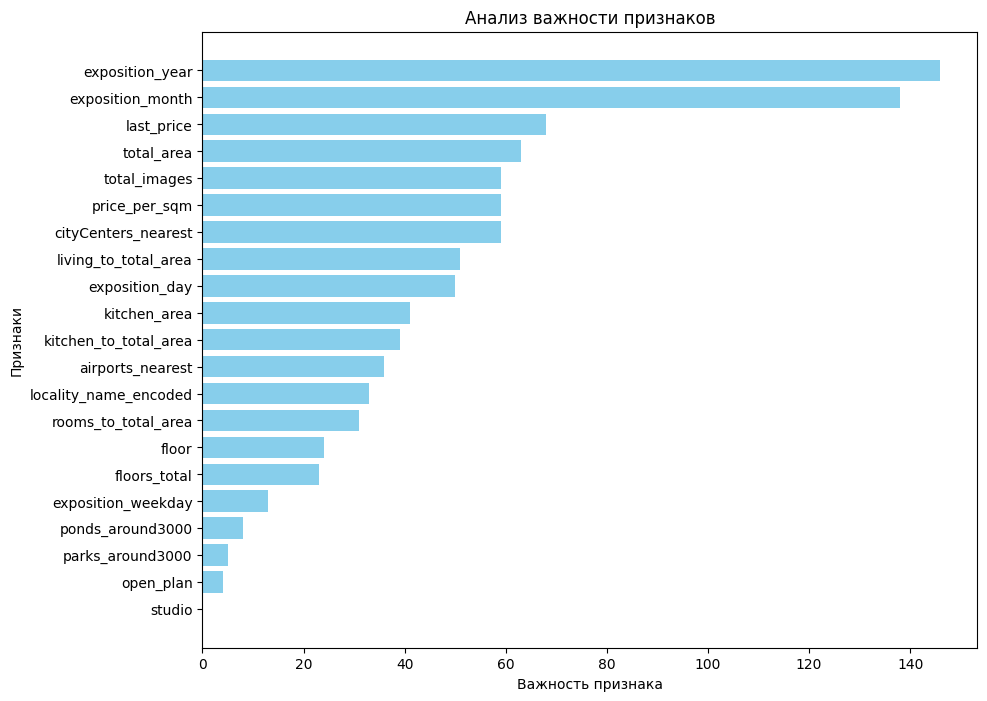

In [31]:
feature_importances = best_model.feature_importances_

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Анализ важности признаков')
plt.gca().invert_yaxis()
plt.show()

Месяц и год публикации объявления играют ключевую роль, возможно, из-за сезонности на рынке недвижимости.  

Как и ожидалось `last_price`, `total_area`, и `total_images` является важным признаком.


# Оценка

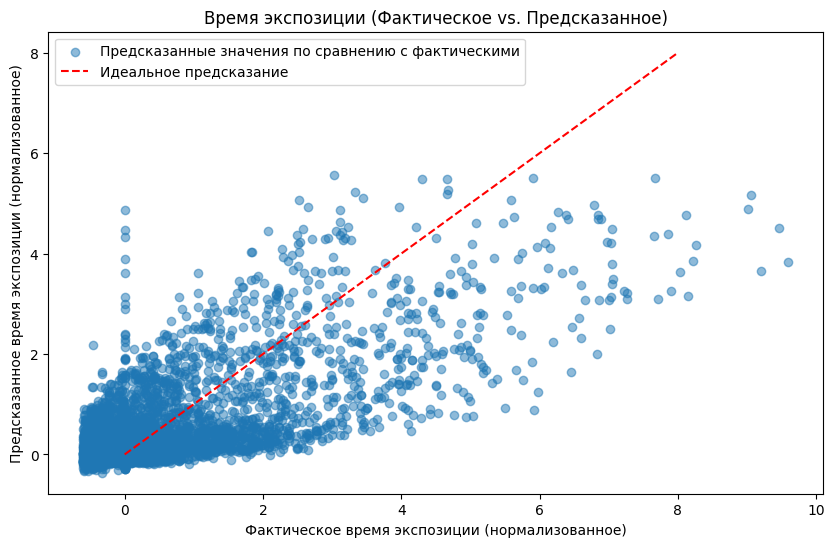

,Actual,Predicted,Error
1109,9.590909,3.832841,5.758068
20969,9.201299,3.643458,5.557841
23540,5.922078,0.878162,5.043916
21755,8.142857,3.156354,4.986503
9553,9.467532,4.508018,4.959515


In [32]:
errors = y_test - y_pred_best

worst_predictions = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_best,
    "Error": errors
}).sort_values(by="Error", key=abs, ascending=False)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5, label="Предсказанные значения по сравнению с фактическими")
plt.plot([0, 8], [0, 8], color='red', linestyle='--', label="Идеальное предсказание")
plt.title("Время экспозиции (Фактическое vs. Предсказанное)")
plt.xlabel("Фактическое время экспозиции (нормализованное)")
plt.ylabel("Предсказанное время экспозиции (нормализованное)")
plt.legend()
plt.show()

worst_predictions.head()


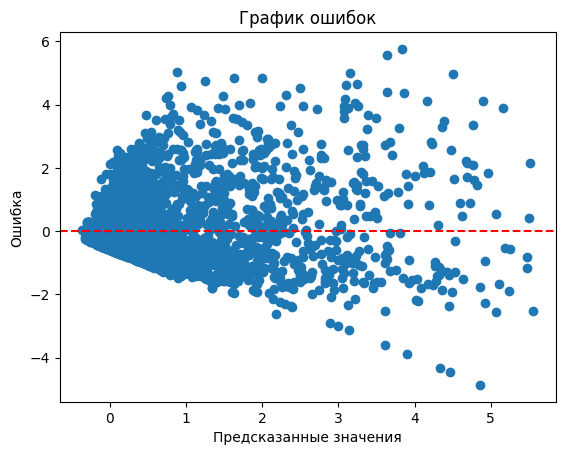

In [33]:
plt.scatter(y_pred_best, errors)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Предсказанные значения")
plt.ylabel("Ошибка")
plt.title("График ошибок")
plt.show()

# Отчёт (вывод)

Топ 5 значимых признаков:  
* exposition_year (Год публикации)
* exposition_month (Месяц публикации)
* last_price (последняя цена квартиры в объявлении)
* total_area (прощадь квартиры)
* total_images (кол-во фото в объявлении)

Анализ ошибок:  
* Модель имеет тенденцию к недооценке времени продажи для объектов с длинным временем экспозиции.   
* Ошибки распределены неравномерно: модель точнее предсказывает короткие сроки экспозиции, тогда как для длинных сроков вариативность предсказаний значительно выше.   

Визуализация результатов:  
В целом, точки на графике фактических меток и предсказанных ложатся приблизительно по линии идеальных предстказаний.
Однако наблюдается увеличение разброса с ростом фактического времени экспозиции, что указывает на сложность модели в предсказании нетипичных случаев.

Качество модели:  
LightGBM с настройкой гиперпараметров имеет R2 равным 51%. Модель лучше справляется с предсказанием короткого времени продажи, чем длинного.
Также стоит изучить сезонность на рынке недвижимости, тк временные признаки (год и месяц объявления) имеют самую высокую значимость.